<a href="https://www.kaggle.com/code/artemsilvander/face-recognition-emotions-tuning-template?scriptVersionId=119606183" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Dataset

AffectNet is a large database of faces labeled by "affects" (psychological term for facial expressions). 
In order to accommodate common memory constraints, the resolution was reduced down to 96x96. 
Meaning that all images are exactly 96x96 pixels.

In [1]:
# let's see what is in labels file

import pandas as pd
from cv2 import cv2
import matplotlib.pyplot as plt  # plot
import os
from os.path import join

path = ('/kaggle/input/affectnet-training-data/')
file = (path + 'labels.csv')
df = pd.read_csv(file)
df.head()

,Unnamed: 0,pth,label,relFCs
0,0,anger/image0000006.jpg,surprise,0.873142
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
3,3,anger/image0000066.jpg,disgust,0.843079
4,4,anger/image0000106.jpg,anger,0.849108


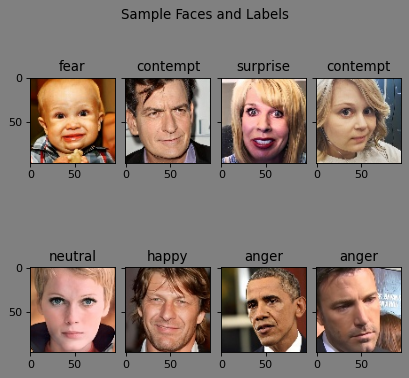

In [2]:
# display random images

import random

fig, axs = plt.subplots(2, 4, sharey=True, constrained_layout=True, num=None, 
                        figsize=(5, 5), dpi=80, facecolor='gray', edgecolor='k')
fig.suptitle("Sample Faces and Labels")
axs = axs.flatten()

for i in range(8):
    idx = random.randint(0, len(df)-1)  # randomly select an index
    img_path = path + df['pth'][idx]
    img = cv2.imread(img_path)  # read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to BGR to RGB
    axs[i].imshow(img)
    axs[i].set_title(df['label'][idx])


In [3]:
# how many emotions categories

import os

INPUT_PATH = "/kaggle/input/affectnet-training-data/"
EMOTIONS = [f.name for f in os.scandir(INPUT_PATH) if f.is_dir()]
IMAGE_SIZE = (96, 96)

print(EMOTIONS)

['surprise', 'fear', 'neutral', 'sad', 'disgust', 'contempt', 'happy', 'anger']


In [4]:
# pre-process the data for CNN

# import cv2
# import numpy as np
# from keras.utils import to_categorical

# X = []
# y = []

# # walk over the folders, save the images in X and y lists and convert them into arrays

# for index, emotion in enumerate(EMOTIONS):
#     for filename in os.listdir(os.path.join(INPUT_PATH, emotion)):
#         img = cv2.imread(os.path.join(INPUT_PATH, emotion, filename))
#         img = cv2.resize(img, (96, 96))
#         #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to BGR to RGB
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert to BGR to GREYscale        
#         X.append(img)
#         y.append(index)

# X = np.array(X).astype('float32') / 255.0 # normalize the X array 
# y = to_categorical(np.array(y)) # make categorical y

# Pre-process

In [5]:
# define functions to pre-process and load images into arrays

import cv2
import numpy as np
from keras.utils import to_categorical
import os

def image_generator(input_path, emotions, image_size):
    for index, emotion in enumerate(emotions):
        for filename in os.listdir(os.path.join(input_path, emotion)):
            img = cv2.imread(os.path.join(input_path, emotion, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            #img = cv2.resize(img, image_size)
            #img = img.astype('float32') / 255.0  # Normilize
            yield img, index

def load_images(input_path, emotions, image_size):
    X, y = [], []
    for img, label in image_generator(input_path, emotions, image_size):
        X.append(img)
        y.append(label)
    X = np.array(X)
    y = to_categorical(np.array(y))
    return X, y

In [6]:
# Load the images
X, y = load_images(INPUT_PATH, EMOTIONS, IMAGE_SIZE)
input_shape = X[0].shape
#input_shape = (96,96,1) 

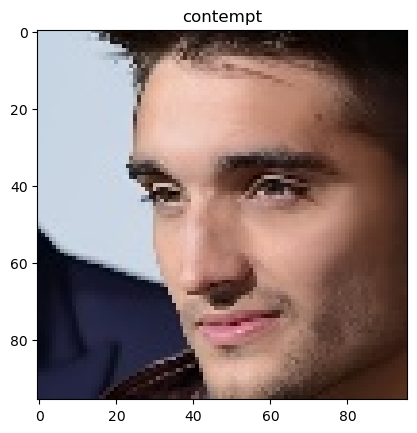

In [7]:
import matplotlib.pyplot as plt

# choose a random image index
idx = np.random.randint(len(X))

# display the image and its corresponding label from arrays
plt.imshow(X[idx])
plt.title(EMOTIONS[np.argmax(y[idx])])
plt.show()


In [8]:
# Train test split pre-processed data

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# # create a stratified train-test split
# split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
# for train_index, test_index in split.split(X, y):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]



# Base model

In [9]:
# Let's try simple caegorical CNN model first

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPool2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(32, (3,3), activation="relu", input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer = Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 94, 94, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 45, 45, 64)       2

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

history = model.fit(X_train, y_train, batch_size=128,
                    epochs=30,
                    validation_data=(X_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, 
                                                 patience=3, min_lr=0.0001)],
                    verbose=1)

Epoch 1/30
182/182 [==============================] - 13s 37ms/step - loss: 7.0683 - accuracy: 0.3071 - val_loss: 6.0519 - val_accuracy: 0.4257 - lr: 1.0000e-04
Epoch 2/30
182/182 [==============================] - 6s 33ms/step - loss: 6.1167 - accuracy: 0.3999 - val_loss: 5.4105 - val_accuracy: 0.4898 - lr: 1.0000e-04
Epoch 3/30
182/182 [==============================] - 6s 33ms/step - loss: 5.4020 - accuracy: 0.4580 - val_loss: 4.8583 - val_accuracy: 0.5085 - lr: 1.0000e-04
Epoch 4/30
182/182 [==============================] - 6s 33ms/step - loss: 4.8169 - accuracy: 0.4916 - val_loss: 4.3603 - val_accuracy: 0.5318 - lr: 1.0000e-04
Epoch 5/30
182/182 [==============================] - 6s 33ms/step - loss: 4.2777 - accuracy: 0.5215 - val_loss: 3.9163 - val_accuracy: 0.5485 - lr: 1.0000e-04
Epoch 6/30
182/182 [==============================] - 6s 35ms/step - loss: 3.8166 - accuracy: 0.5407 - val_loss: 3.5171 - val_accuracy: 0.5653 - lr: 1.0000e-04
Epoch 7/30
182/182 [===================

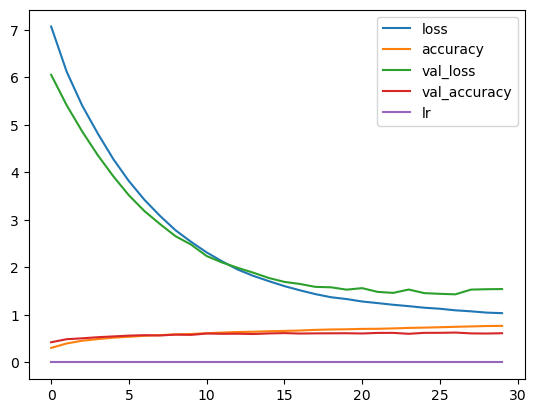

In [11]:
pd.DataFrame(history.history).plot();

In [12]:
from sklearn.metrics import r2_score

# Make predictions
y_pred = model.predict(X_test)

# Calculate R2 score
r2 = r2_score(y_test, y_pred)

print("R2 score:", r2)

182/182 [==============================] - 1s 3ms/step
R2 score: 0.3517031753674793


In [13]:
# Compute classification report

from sklearn.metrics import classification_report

# Convert one-hot encoded y_test back to integers
y_test_int = np.argmax(y_test, axis=1)

# Make predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded y_pred back to integers
y_pred_int = np.argmax(y_pred, axis=1)

# Generate classification report
print(classification_report(y_test_int, y_pred_int))


182/182 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.47      0.62      0.54       815
           1       0.71      0.22      0.33       660
           2       0.86      0.83      0.85       982
           3       0.43      0.53      0.47       582
           4       0.46      0.38      0.42       517
           5       0.48      0.69      0.56       578
           6       0.87      0.92      0.90       988
           7       0.52      0.43      0.47       687

    accuracy                           0.62      5809
   macro avg       0.60      0.58      0.57      5809
weighted avg       0.63      0.62      0.60      5809



# Functions for Tuning

In [14]:
# base model configuratioon

def base_model_config():
    model_config = {
            "HIDDEN_NODES" : [64,128,256,512],
            "HIDDEN_ACTIVATION" : "relu",
            "PADDING" : "same",
            "OUTPUT_NODES" : 8,
            "OUTPUT_ACTIVATION" : "softmax",
            "WEIGHTS_INITIALIZER" : "random_normal",
            "BIAS_INITIALIZER" : "zeros",
            "NORMALIZATION" : "none",
            "OPTIMIZER" : "adam",
            "LEARNING_RATE" : 0.0001,
            "REGULARIZER" : None,
            "DROPOUT_RATE" : 0.0,
            "EPOCHS" : 25,
            "BATCH_SIZE" : 64,
            "VALIDATION_SPLIT" : 0.2,
            "VERBOSE" : 1,
            "LOSS_FUNCTION" : "categorical_crossentropy",
            "METRICS" : ["accuracy"]
            }
    return model_config

In [15]:
from tensorflow import keras

def get_optimizer(optimizer_name, learning_rate):
    optimizer = None
    
    if optimizer_name == 'adagrad':
        optimizer = keras.optimizers.Adagrad(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_name == 'adadelta':
        optimizer = keras.optimizers.Adadelta(learning_rate=learning_rate)
    elif optimizer_name == 'adamax':
        optimizer = keras.optimizers.Adamax(learning_rate=learning_rate)
    elif optimizer_name == 'nadam':
        optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)
    elif optimizer_name == 'ftrl':
        optimizer = keras.optimizers.Ftrl(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    return optimizer

In [16]:
# main template function MODEL run

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPool2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

def create_and_run_model(model_config,X,Y,model_name) :
    
    model = Sequential()

    model.add(Conv2D(32, (3,3), activation="relu", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='softmax'))

    model.compile(optimizer = Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    for layer in range(len(model_config["HIDDEN_NODES"])):
        
        if (layer == 0):
            model.add(
                    keras.layers.Dense(model_config["HIDDEN_NODES"][layer],
                    input_shape=(X.shape[1],),
                    name="Dense-Layer-" + str(layer),
                    kernel_initializer = model_config["WEIGHTS_INITIALIZER"],
                    bias_initializer = model_config["BIAS_INITIALIZER"],
                    kernel_regularizer=model_config["REGULARIZER"],
                    activation=model_config["HIDDEN_ACTIVATION"]))
        else:
            
            if ( model_config["NORMALIZATION"] == "batch"):
                model.add(keras.layers.BatchNormalization())
                
            if ( model_config["DROPOUT_RATE"] > 0.0 ):
                model.add(keras.layers.Dropout(model_config["DROPOUT_RATE"]))
                
            model.add(
                    keras.layers.Dense(model_config["HIDDEN_NODES"][layer],
                    name="Dense-Layer-" + str(layer),
                    kernel_initializer = model_config["WEIGHTS_INITIALIZER"],
                    bias_initializer = model_config["BIAS_INITIALIZER"],
                    kernel_regularizer=model_config["REGULARIZER"],
                    activation=model_config["HIDDEN_ACTIVATION"])) 
            

            
    model.add(keras.layers.Dense(model_config["OUTPUT_NODES"],
                    name="Output-Layer",
                    activation=model_config["OUTPUT_ACTIVATION"]))
    
    optimizer = get_optimizer( model_config["OPTIMIZER"],
                              model_config["LEARNING_RATE"])
    
    model.compile(loss=model_config["LOSS_FUNCTION"],
                  optimizer=optimizer,
                   metrics=model_config["METRICS"])
    
    print("\n******************************************************")
    model.summary()
    
    X_train, X_val, Y_train, Y_val =train_test_split(
                        X,Y,
                        test_size=model_config["VALIDATION_SPLIT"]) 
    
    callbacks = [EarlyStopping(patience=4, monitor='val_loss', mode='min'), 
                 ReduceLROnPlateau(patience=2, verbose=1),
                 ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True, 
                             monitor='val_accuracy', mode='max', verbose=1)]
    
    history=model.fit(X_train,
          Y_train,
          batch_size=model_config["BATCH_SIZE"],
          epochs=model_config["EPOCHS"],
          verbose=model_config["VERBOSE"],
          callbacks=callbacks,
          validation_data= (X_val, Y_val))
    
    return history

In [17]:
def plot_graph(mse, title):
    
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(15, 8))
    for experiment in accuracy_measures.keys():
        plt.plot(accuracy_measures[experiment], 
                 label=experiment,
                    linewidth=3)
        
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

# Batch size

In [18]:
accuracy_measures = {}

for batch_size in range(32,256,32):
    
    #Load default configuration
    model_config = base_model_config()
    
    #set epoch to 
    model_config["EPOCHS"]=25
    
    #Set batch size to experiment value
    model_config["BATCH_SIZE"] = batch_size
    model_name = "Batch-Size-" + str(batch_size)
    history=create_and_run_model(model_config,X,y,model_name)
    
    # Train the model
    accuracy_measures[model_name] = history.history["accuracy"]


******************************************************
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 94, 94, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 47, 47, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/25
727/727 [==============================] - ETA: 0s - loss: 2.3785 - accuracy: 0.2583
Epoch 1: val_accuracy improved from -inf to 0.28284, saving model to best_model.h5
727/727 [==============================] - 11s 14ms/step - loss: 2.3785 - accuracy: 0.2583 - val_loss: 1.7651 - val_accuracy: 0.2828 - lr: 1.0000e-04
Epoch 2/25
726/727 [============================>.] - ETA: 0s - loss: 1.7209 - accuracy: 0.3193
Epoch 2: val_accuracy improved from 0.28284 to 0.35497, saving model to best_model.h5
727/727 [==============================] - 9s 12ms/step - loss: 1.7210 - accuracy: 0.3193 - val_loss: 1.6711 - val_accuracy: 0.3550 - lr: 1.0000e-04
Epoch 3/25
724/727 [============================>.] - ETA: 0s - loss: 1.6367 - accuracy: 0.3809
Epoch 3: val_accuracy improved from 0.35497 to 0.41281, saving model to best_model.h5
727/727 [==============================] - 9s 13ms/step - loss: 1.6367 - accuracy: 0.3810 - val_loss: 1.5992 - val_accuracy: 0.4128 - lr: 1.0000e-04
Epoch 4/2

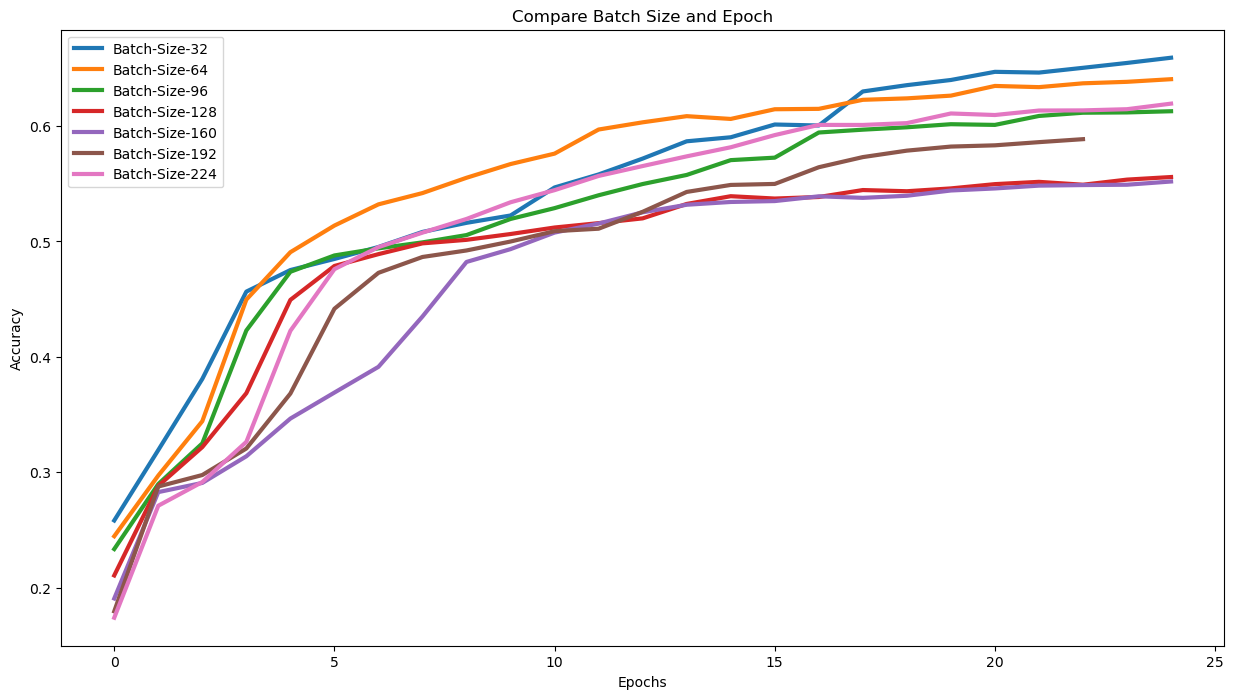

In [19]:
plot_graph(accuracy_measures, "Compare Batch Size and Epoch")

# Activation functions

In [20]:
accuracy_measures = {}

activation_list = ['elu', 'selu', 'swish','relu']

for activation in activation_list:
    
    model_config = base_model_config()
        
    model_config["HIDDEN_ACTIVATION"] = activation
    model_name = "Model-" + activation
    history=create_and_run_model(model_config,X,y,model_name)
    
    accuracy_measures["Model-" + activation] = history.history["accuracy"]


******************************************************
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_32 (Bat  (None, 94, 94, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 47, 47, 32)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                

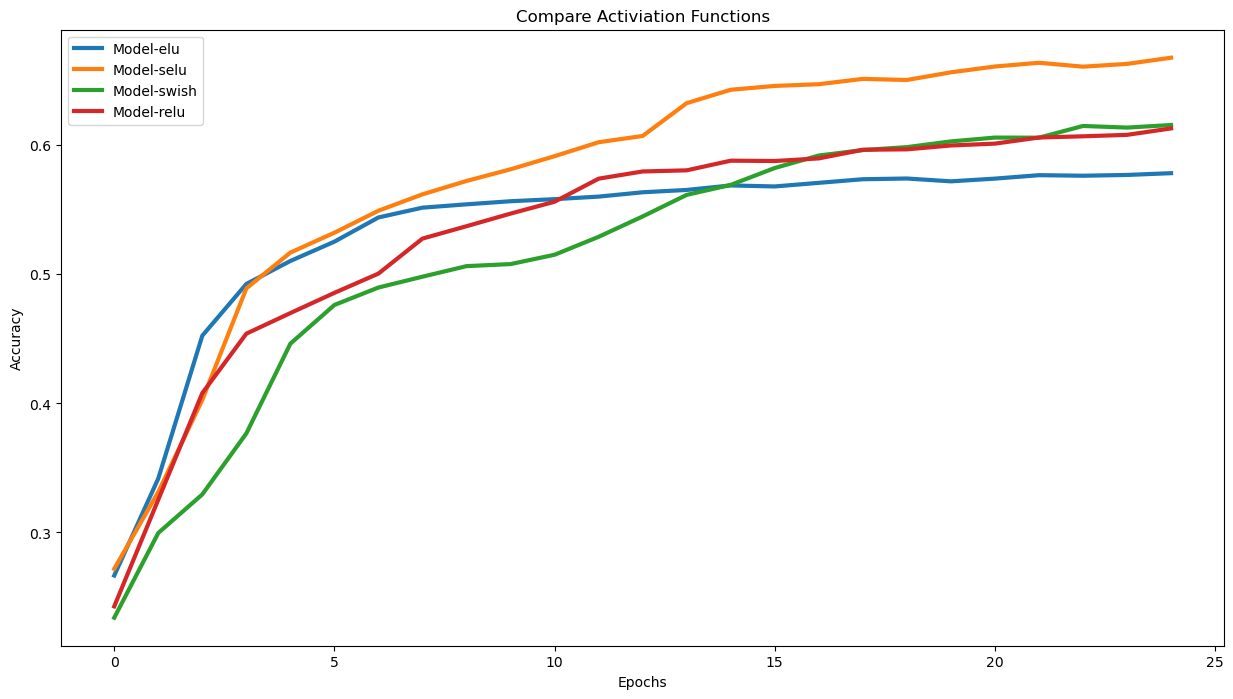

In [21]:
plot_graph(accuracy_measures, "Compare Activiation Functions")

In [22]:
# what an interesting discovery, let's test more SELU activation function

# base model configuratioon

def base_model_config():
    model_config = {
            "HIDDEN_NODES" : [64,128,256,512],
            "HIDDEN_ACTIVATION" : "selu",
            "PADDING" : "same",
            "OUTPUT_NODES" : 8,
            "OUTPUT_ACTIVATION" : "softmax",
            "WEIGHTS_INITIALIZER" : "random_normal",
            "BIAS_INITIALIZER" : "zeros",
            "NORMALIZATION" : "none",
            "OPTIMIZER" : "adam",
            "LEARNING_RATE" : 0.0001,
            "REGULARIZER" : None,
            "DROPOUT_RATE" : 0.0,
            "EPOCHS" : 25,
            "BATCH_SIZE" : 64,
            "VALIDATION_SPLIT" : 0.2,
            "VERBOSE" : 1,
            "LOSS_FUNCTION" : "categorical_crossentropy",
            "METRICS" : ["accuracy"]
            }
    return model_config

# Optimizers

In [23]:
accuracy_measures = {}

optimizer_list = ['rmsprop', 'adam', 'adagrad', 'adamax']
for optimizer in optimizer_list:
    
    model_config = base_model_config()
    
    model_config["OPTIMIZER"] = optimizer
    model_name = "Optimizer-" + optimizer
    history=create_and_run_model(model_config,X,y, model_name)
    
    accuracy_measures[model_name] = history.history["accuracy"]


******************************************************
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_48 (Bat  (None, 94, 94, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 dropout_48 (Dropout)        (None, 47, 47, 32)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 45, 45, 64)        18496     
                                                               

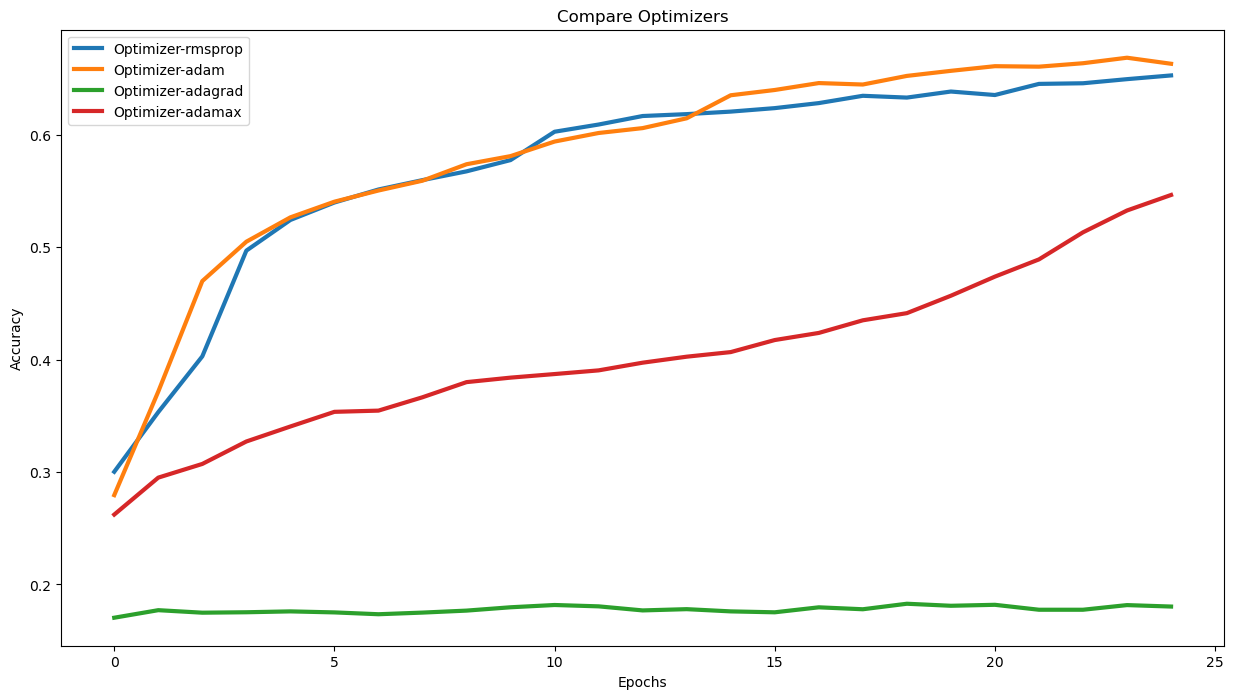

In [24]:
plot_graph(accuracy_measures, "Compare Optimizers")

# Learning rate

In [25]:
accuracy_measures = {}

learning_rate_list = [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01]
for learning_rate in learning_rate_list:
    
    model_config = base_model_config()
    
    model_config["LEARNING_RATE"] = learning_rate
    model_name="Learning-Rate-" + str(learning_rate)
    history=create_and_run_model(model_config,X,y, model_name)
    
    #accuracy
    accuracy_measures[model_name] = history.history["accuracy"]


******************************************************
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_64 (Bat  (None, 94, 94, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 dropout_64 (Dropout)        (None, 47, 47, 32)        0         
                                                                 
 conv2d_49 (Conv2D)          (None, 45, 45, 64)        18496     
                                                               

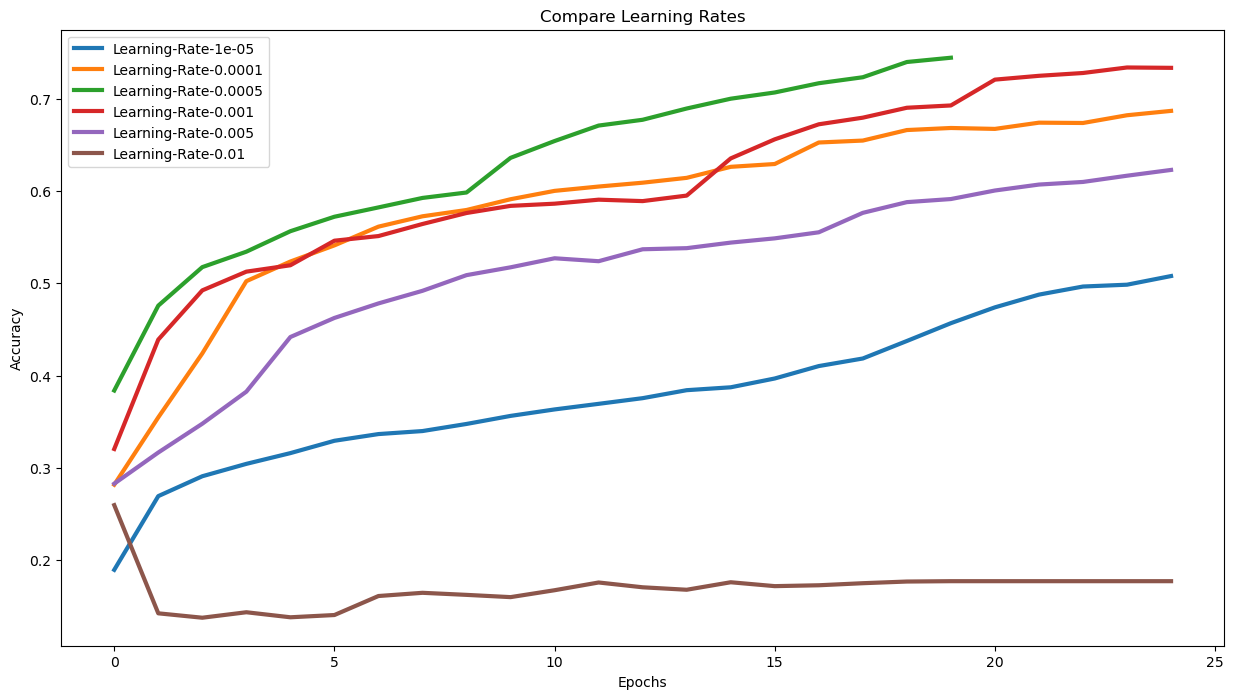

In [26]:
plot_graph(accuracy_measures, "Compare Learning Rates")

# Updated Model

In [27]:
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPool2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

model_2 = Sequential()

model_2.add(Conv2D(32, (3,3), activation="selu", input_shape=input_shape))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(64, (3,3), activation="selu"))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(128, (3,3), activation="selu"))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(256, activation='selu', kernel_regularizer=l2(0.01)))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))
model_2.add(Dense(8, activation='softmax'))

model_2.compile(optimizer = Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_2.summary()


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_88 (Bat  (None, 94, 94, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 dropout_88 (Dropout)        (None, 47, 47, 32)        0         
                                                                 
 conv2d_67 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_89 (Bat  (None, 45, 45, 64)     

In [28]:
history = model_2.fit(X_train, y_train, batch_size=64,
                    epochs=30,
                    validation_data=(X_test, y_test),
                    
                    callbacks = [EarlyStopping(patience=10, monitor='val_loss', mode='min'), 
                                 ReduceLROnPlateau(patience=2, verbose=1),
                                 ModelCheckpoint('best_model.h5', 
                                                 save_best_only=True, 
                                                 save_weights_only=True, 
                                                 monitor='val_accuracy', 
                                                 mode='max')],
                    verbose=1)

Epoch 1/30
364/364 [==============================] - 8s 20ms/step - loss: 4.0055 - accuracy: 0.4408 - val_loss: 3.3480 - val_accuracy: 0.4142 - lr: 0.0010
Epoch 2/30
364/364 [==============================] - 7s 19ms/step - loss: 2.2351 - accuracy: 0.5260 - val_loss: 2.4535 - val_accuracy: 0.4663 - lr: 0.0010
Epoch 3/30
364/364 [==============================] - 7s 18ms/step - loss: 2.1209 - accuracy: 0.5579 - val_loss: 2.4401 - val_accuracy: 0.4731 - lr: 0.0010
Epoch 4/30
364/364 [==============================] - 7s 18ms/step - loss: 1.9956 - accuracy: 0.5705 - val_loss: 2.1189 - val_accuracy: 0.5011 - lr: 0.0010
Epoch 5/30
364/364 [==============================] - 7s 19ms/step - loss: 1.9475 - accuracy: 0.5889 - val_loss: 1.9522 - val_accuracy: 0.5831 - lr: 0.0010
Epoch 6/30
364/364 [==============================] - 7s 18ms/step - loss: 1.9623 - accuracy: 0.5943 - val_loss: 2.0440 - val_accuracy: 0.5636 - lr: 0.0010
Epoch 7/30
363/364 [============================>.] - ETA: 0s - 

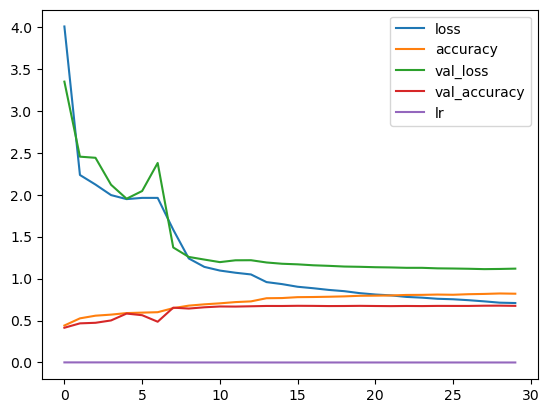

In [29]:
pd.DataFrame(history.history).plot();

In [30]:
from sklearn.metrics import r2_score

# Make predictions
y_pred = model_2.predict(X_test)

# Calculate R2 score
r2 = r2_score(y_test, y_pred)

print("R2 score:", r2)

182/182 [==============================] - 1s 3ms/step
R2 score: 0.45522464221462455


In [31]:
# Compute classification report

from sklearn.metrics import classification_report

# Convert one-hot encoded y_test back to integers
y_test_int = np.argmax(y_test, axis=1)

# Make predictions
y_pred = model_2.predict(X_test)

# Convert one-hot encoded y_pred back to integers
y_pred_int = np.argmax(y_pred, axis=1)

# Generate classification report
print(classification_report(y_test_int, y_pred_int))

182/182 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.57      0.63      0.60       815
           1       0.62      0.44      0.51       660
           2       0.85      0.90      0.87       982
           3       0.53      0.51      0.52       582
           4       0.51      0.50      0.50       517
           5       0.57      0.73      0.64       578
           6       0.92      0.91      0.92       988
           7       0.57      0.53      0.55       687

    accuracy                           0.67      5809
   macro avg       0.64      0.64      0.64      5809
weighted avg       0.67      0.67      0.67      5809

